# Random Walk

In [13]:
import pandas as pd
import numpy as np
from math import exp, sqrt

# -------------------- Parameters --------------------
np.random.seed(42)

N_PATHS = 10000
N_STEPS = 32
T = 2.0
dt = T / N_STEPS
sqrt_dt = sqrt(dt)

r = 0.03
rho = 0.2
sigma1, sigma2 = 0.30, 0.40
S01, S02 = 100.0, 100.0
notional = 100.0

# Step-down autocall
autocall_steps = [8, 16, 24]                 # 6m, 12m, 18m
autocall_levels = [0.85, 0.80, 0.75]
autocall_coupons = [0.0625, 0.125, 0.1875]

# Maturity
maturity_win_level = 0.70
maturity_coupon = 0.25
knock_in_level = 0.60

In [14]:
# -------------------- 1. 난수 생성 (independent standard normal) --------------------
Z = np.random.randn(N_PATHS, N_STEPS, 2)  # (paths, steps, assets)

# -------------------- 2. 상관 반영 --------------------
Z_corr = np.empty_like(Z)
Z_corr[:,:,0] = Z[:,:,0]
Z_corr[:,:,1] = rho * Z[:,:,0] + sqrt(1 - rho**2) * Z[:,:,1]

# -------------------- 3. GBM 경로 생성 + ELS 페이오프 --------------------
discounted_payoffs = np.zeros(N_PATHS)
cases = np.zeros(N_PATHS, dtype=int)  # 1~6

for i in range(N_PATHS):
    S1, S2 = S01, S02
    knocked_in = False
    paid = False

    for j in range(N_STEPS):
        # 난수 가져오기
        z1c, z2c = Z_corr[i,j,0], Z_corr[i,j,1]

        # GBM 업데이트
        S1 = S1 * np.exp((r - 0.5*sigma1**2)*dt + sigma1*sqrt_dt*z1c)
        S2 = S2 * np.exp((r - 0.5*sigma2**2)*dt + sigma2*sqrt_dt*z2c)

        # 녹인 여부 체크
        if S1 < knock_in_level*S01 or S2 < knock_in_level*S02:
            knocked_in = True

        # 조기상환 체크
        if (j+1) in autocall_steps:
            idx = autocall_steps.index(j+1)
            level = autocall_levels[idx]
            coupon = autocall_coupons[idx]
            if S1 >= level*S01 and S2 >= level*S02:
                payoff = notional*(1+coupon)
                discounted_payoffs[i] = payoff * exp(-r * (j+1)*dt)
                cases[i] = idx+1   # 1,2,3
                paid = True
                break

    # 만기
    if not paid:
        worst_ratio = min(S1/S01, S2/S02)
        if S1 >= maturity_win_level*S01 and S2 >= maturity_win_level*S02:
            payoff = notional*(1+maturity_coupon)
            case = 4
        elif not knocked_in:
            payoff = notional
            case = 5
        else:
            payoff = notional*worst_ratio
            case = 6
        discounted_payoffs[i] = payoff * exp(-r*T)
        cases[i] = case

# -------------------- 4. value & standard error --------------------
value = discounted_payoffs.mean()
std_dev = discounted_payoffs.std(ddof=1)
standard_error = std_dev / np.sqrt(N_PATHS)

# -------------------- 5. Case별 집계 --------------------
unique, counts = np.unique(cases, return_counts=True)
prob = counts / N_PATHS * 100

case_labels = {
    1: "Autocall 6M (≥85%)",
    2: "Autocall 12M (≥80%)",
    3: "Autocall 18M (≥75%)",
    4: "Maturity: both ≥70% (+25%)",
    5: "Maturity: <70%, no KI → principal",
    6: "Maturity: <70%, KI → worst-of"
}

case_table = pd.DataFrame({
    "case": unique,
    "description": [case_labels[c] for c in unique],
    "count": counts,
    "prob(%)": np.round(prob, 2)
})

# -------------------- 6. 결과 출력 --------------------
print(f"value = {value:.2f}")
print(f"standard error = {standard_error:.2f}")
case_table


value = 93.20
standard error = 0.27


,case,description,count,prob(%)
0,1,Autocall 6M (≥85%),5442,54.42
1,2,Autocall 12M (≥80%),1332,13.32
2,3,Autocall 18M (≥75%),639,6.39
3,4,Maturity: both ≥70% (+25%),398,3.98
4,5,"Maturity: <70%, no KI → principal",34,0.34
5,6,"Maturity: <70%, KI → worst-of",2155,21.55


# Brownian Bridge

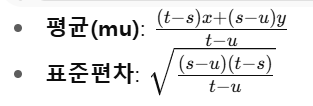

### *1. 모든 경로에 대해 브라운 브릿지 수행한 경우*

In [24]:
import numpy as np
import pandas as pd

np.random.seed(42)

# -------------------- 공통 파라미터 --------------------
T        = 2.0               # 총 기간(년)
N_STEPS  = 32                # 최종 세밀격자 step 수
dt       = T / N_STEPS       # 한 step 길이(년)
N_PATHS  = 10_000            # 경로 수

r   = 0.03
rho = 0.20
sigma1, sigma2 = 0.30, 0.40
S01, S02 = 100.0, 100.0
notional = 100.0

# ELS 조건
autocall_levels   = [0.85, 0.80, 0.75]
autocall_coupons  = [0.0625, 0.125, 0.1875]
autocall_times    = np.array([8, 16, 24]) * dt   # 6m, 12m, 18m (절대시간)
maturity_win_level = 0.70
maturity_coupon    = 0.25
knock_in_level     = 0.60
H1, H2 = knock_in_level*S01, knock_in_level*S02

# -------------------- coarse Wiener 경로 (0,8,16,24,32) 생성 --------------------
idx_coarse = np.array([0, 8, 16, 24, 32], dtype=int)  # 세밀격자 index
t_coarse   = idx_coarse * dt                           # [0, 8*dt, ... , 32*dt]

W1_coarse = np.zeros((N_PATHS, len(t_coarse)))
W2_coarse = np.zeros((N_PATHS, len(t_coarse)))

for j in range(1, len(t_coarse)):
    h = t_coarse[j] - t_coarse[j-1]      # = 8*dt
    z1 = np.random.randn(N_PATHS)
    z2 = np.random.randn(N_PATHS)
    dW1 = np.sqrt(h) * z1
    dW2 = np.sqrt(h) * (rho*z1 + np.sqrt(1 - rho**2)*z2)
    W1_coarse[:, j] = W1_coarse[:, j-1] + dW1
    W2_coarse[:, j] = W2_coarse[:, j-1] + dW2

# -------------------- 브라운 브릿지 1-step refine --------------------
def bridge_refine_once(t, W1, W2, rho):
    """
    각 구간 [u,t]의 중간 s=(u+t)/2에서
    W(s) | W(u)=x, W(t)=y ~ N( ((t-s)x + (s-u)y)/(t-u), (s-u)(t-s)/(t-u) )
    를 이용해 중간점을 샘플링하고, 격자를 2배로 정제한다.
    """
    N, M = W1.shape
    tL, tR = t[:-1], t[1:]
    t_mid  = 0.5*(tL + tR)
    h      = (tR - tL)
    var_mid = (t_mid - tL)*(tR - t_mid)/h
    alpha   = (t_mid - tL)/h

    mu1 = (1 - alpha)[None,:]*W1[:, :-1] + alpha[None,:]*W1[:, 1:]
    mu2 = (1 - alpha)[None,:]*W2[:, :-1] + alpha[None,:]*W2[:, 1:]

    u = np.random.randn(N, M-1)
    v = np.random.randn(N, M-1)
    noise1 = np.sqrt(var_mid)[None,:] * u
    noise2 = np.sqrt(var_mid)[None,:] * (rho*u + np.sqrt(1 - rho**2)*v)

    W1_mid = mu1 + noise1
    W2_mid = mu2 + noise2

    t_new = np.empty(2*M-1); t_new[0::2] = t; t_new[1::2] = t_mid
    W1_new = np.empty((N, 2*M-1)); W2_new = np.empty((N, 2*M-1))
    W1_new[:, 0::2] = W1;          W1_new[:, 1::2] = W1_mid
    W2_new[:, 0::2] = W2;          W2_new[:, 1::2] = W2_mid
    return t_new, W1_new, W2_new

# -------------------- 유틸: 특정 절대시간에 해당하는 index 찾기 --------------------
def idx_for_time(t_array, t_target):
    return int(np.argmin(np.abs(t_array - t_target)))

# -------------------- 한 단계(0,1,2,3 refine) 평가 함수 --------------------
def run_stage(num_refines):
    # coarse에서 시작해 num_refines번 브릿지 수행
    t, W1, W2 = t_coarse.copy(), W1_coarse.copy(), W2_coarse.copy()
    for _ in range(num_refines):
        t, W1, W2 = bridge_refine_once(t, W1, W2, rho)

    # GBM 경로
    drift1 = (r - 0.5*sigma1**2) * t[None, :]
    drift2 = (r - 0.5*sigma2**2) * t[None, :]
    S1 = S01 * np.exp(drift1 + sigma1 * W1)
    S2 = S02 * np.exp(drift2 + sigma2 * W2)

    # 평가 (케이스/페이오프)
    discounted = np.zeros(N_PATHS)
    cases = np.zeros(N_PATHS, dtype=int)

    # autocall용 인덱스(해당 절대시간의 recently exact index)
    ac_idx = [idx_for_time(t, tt) for tt in autocall_times]

    for i in range(N_PATHS):
        s1, s2 = S1[i], S2[i]
        knocked_in = np.any((s1 < H1) | (s2 < H2))
        paid = False

        # 6m/12m/18m
        for k, j_ac in enumerate(ac_idx):
            if (s1[j_ac] >= autocall_levels[k]*S01) and (s2[j_ac] >= autocall_levels[k]*S02):
                payoff = notional*(1 + autocall_coupons[k])
                discounted[i] = payoff * np.exp(-r * t[j_ac])
                cases[i] = k+1
                paid = True
                break

        if not paid:
            s1T, s2T = s1[-1], s2[-1]
            worst_ratio = min(s1T/S01, s2T/S02)
            if (s1T >= maturity_win_level*S01) and (s2T >= maturity_win_level*S02):
                payoff = notional*(1 + maturity_coupon); case = 4
            elif not knocked_in:
                payoff = notional;                            case = 5
            else:
                payoff = notional*worst_ratio;               case = 6
            discounted[i] = payoff * np.exp(-r*T)
            cases[i] = case

    value = discounted.mean()
    std_err = discounted.std(ddof=1)/np.sqrt(N_PATHS)

    labels = {
        1: "Autocall 6M (≥85%)",
        2: "Autocall 12M (≥80%)",
        3: "Autocall 18M (≥75%)",
        4: "Maturity: both ≥70% (+25%)",
        5: "Maturity: <70%, no KI → principal",
        6: "Maturity: <70%, KI → worst-of",
    }
    unique, counts = np.unique(cases, return_counts=True)
    prob = 100.0 * counts / N_PATHS
    case_table = pd.DataFrame({
        "case": unique,
        "description": [labels[c] for c in unique],
        "count": counts,
        "prob(%)": np.round(prob, 2)
    }).sort_values("case")

    return value, std_err, case_table

# -------------------- 4단계(0,1,2,3) 결과 출력 --------------------
for stage in range(4):
    val, se, tbl = run_stage(stage)
    print("\n" + "="*70)
    if stage == 0:
        print(f"[Stage {stage}] 브라운 브릿지 미적용 (0-8-16-24-32)")
    else:
        print(f"[Stage {stage}] 브라운 브릿지 {stage}단계 적용")
    print(f"value = {val:.2f}")
    print(f"standard error = {se:.2f}")
    print(tbl.to_string(index=False))



[Stage 0] 브라운 브릿지 미적용 (0-8-16-24-32)
value = 93.66
standard error = 0.26
 case                       description  count  prob(%)
    1                Autocall 6M (≥85%)   5481    54.81
    2               Autocall 12M (≥80%)   1220    12.20
    3               Autocall 18M (≥75%)    665     6.65
    4        Maturity: both ≥70% (+25%)    436     4.36
    5 Maturity: <70%, no KI → principal    183     1.83
    6     Maturity: <70%, KI → worst-of   2015    20.15

[Stage 1] 브라운 브릿지 1단계 적용
value = 93.44
standard error = 0.27
 case                       description  count  prob(%)
    1                Autocall 6M (≥85%)   5481    54.81
    2               Autocall 12M (≥80%)   1220    12.20
    3               Autocall 18M (≥75%)    665     6.65
    4        Maturity: both ≥70% (+25%)    436     4.36
    5 Maturity: <70%, no KI → principal    115     1.15
    6     Maturity: <70%, KI → worst-of   2083    20.83

[Stage 2] 브라운 브릿지 2단계 적용
value = 93.29
standard error = 0.27
 case             

### *2. 5번 케이스에 해당하는 경로에 대해서만 브라운 브릿지 수행한 경우*

In [26]:
import numpy as np
import pandas as pd

np.random.seed(42)

# -------------------- 공통 파라미터 --------------------
T        = 2.0               # 총 기간(년)
N_STEPS  = 32                # 최종 세밀격자 step 수 (= 2년을 32개로)
dt       = T / N_STEPS       # 한 step 길이(년)
N_PATHS  = 10_000            # 경로 수

r   = 0.03
rho = 0.20
sigma1, sigma2 = 0.30, 0.40
S01, S02 = 100.0, 100.0
notional = 100.0

# ELS 조건
autocall_levels    = [0.85, 0.80, 0.75]
autocall_coupons   = [0.0625, 0.125, 0.1875]
autocall_times_abs = np.array([8, 16, 24]) * dt   # 절대시간: 6m, 12m, 18m
maturity_win_level = 0.70
maturity_coupon    = 0.25
knock_in_level     = 0.60
H1, H2 = knock_in_level*S01, knock_in_level*S02

# -------------------- (A) coarse Wiener 경로 0-8-16-24-32 생성 --------------------
idx_coarse = np.array([0, 8, 16, 24, 32], dtype=int)
t_coarse   = idx_coarse * dt  # shape (5,)

W1 = np.zeros((N_PATHS, len(t_coarse)))
W2 = np.zeros((N_PATHS, len(t_coarse)))
for j in range(1, len(t_coarse)):
    h = t_coarse[j] - t_coarse[j-1]                # = 8*dt
    z1 = np.random.randn(N_PATHS)
    z2 = np.random.randn(N_PATHS)
    dW1 = np.sqrt(h) * z1
    dW2 = np.sqrt(h) * (rho*z1 + np.sqrt(1 - rho**2) * z2)
    W1[:, j] = W1[:, j-1] + dW1
    W2[:, j] = W2[:, j-1] + dW2

# -------------------- (B) 브라운 브릿지 1회 (단일 경로) --------------------
def bridge_refine_once_single(t, w1, w2, rho):
    """
    단일 경로에 대해 브라운 브릿지 한 번: 각 구간 중간점에 W(s)를 조건부분포로 샘플
    입력: t (M,), w1 (M,), w2 (M,)
    출력: t_new (2M-1,), w1_new, w2_new
    """
    tL, tR = t[:-1], t[1:]
    t_mid  = 0.5 * (tL + tR)
    h      = (tR - tL)
    var_mid = (t_mid - tL) * (tR - t_mid) / h
    alpha   = (t_mid - tL) / h

    mu1 = (1 - alpha) * w1[:-1] + alpha * w1[1:]
    mu2 = (1 - alpha) * w2[:-1] + alpha * w2[1:]

    u = np.random.randn(len(t) - 1)
    v = np.random.randn(len(t) - 1)
    n1 = np.sqrt(var_mid) * u
    n2 = np.sqrt(var_mid) * (rho*u + np.sqrt(1 - rho**2)*v)

    w1_mid = mu1 + n1
    w2_mid = mu2 + n2

    t_new  = np.empty(2*len(t)-1); t_new[0::2] = t;    t_new[1::2] = t_mid
    w1_new = np.empty_like(t_new);  w1_new[0::2] = w1; w1_new[1::2] = w1_mid
    w2_new = np.empty_like(t_new);  w2_new[0::2] = w2; w2_new[1::2] = w2_mid
    return t_new, w1_new, w2_new

# -------------------- (C) 유틸: 절대시간에 가장 가까운 인덱스 --------------------
def idx_for_time(t_array, t_target):
    return int(np.argmin(np.abs(t_array - t_target)))

# -------------------- (D) 단일 경로 평가 (현재 보유한 t, w1, w2 사용) --------------------
def evaluate_one_path(t, w1, w2):
    """주어진 경로로 GBM 가격을 만들고 케이스/할인지급을 반환"""
    drift1 = (r - 0.5*sigma1**2) * t
    drift2 = (r - 0.5*sigma2**2) * t
    s1 = S01 * np.exp(drift1 + sigma1*w1)
    s2 = S02 * np.exp(drift2 + sigma2*w2)

    knocked_in = np.any((s1 < H1) | (s2 < H2))  # 현재 격자에서의 녹인 체크
    # 조기상환
    paid = False
    ac_idx = [idx_for_time(t, tt) for tt in autocall_times_abs]
    for k, j_ac in enumerate(ac_idx):
        if (s1[j_ac] >= autocall_levels[k]*S01) and (s2[j_ac] >= autocall_levels[k]*S02):
            payoff = notional * (1.0 + autocall_coupons[k])
            pv = payoff * np.exp(-r * t[j_ac])
            return k+1, pv  # case 1,2,3
    # 만기
    s1T, s2T = s1[-1], s2[-1]
    worst_ratio = min(s1T/S01, s2T/S02)
    if (s1T >= maturity_win_level*S01) and (s2T >= maturity_win_level*S02):
        case = 4; payoff = notional*(1.0 + maturity_coupon)
    elif not knocked_in:
        case = 5; payoff = notional
    else:
        case = 6; payoff = notional*worst_ratio
    pv = payoff * np.exp(-r*T)
    return case, pv

# -------------------- (E) Stage 0: 브릿지 미적용으로 분류 --------------------
# 전 경로 coarse 격자로 평가
cases = np.zeros(N_PATHS, dtype=int)
pvs   = np.zeros(N_PATHS)
# 선택적 refine을 위해 각 경로의 현재 (t,w1,w2)를 보관
current_t  = [t_coarse.copy() for _ in range(N_PATHS)]
current_w1 = [None]*N_PATHS
current_w2 = [None]*N_PATHS
for i in range(N_PATHS):
    current_w1[i] = W1[i].copy()
    current_w2[i] = W2[i].copy()
    c, pv = evaluate_one_path(current_t[i], current_w1[i], current_w2[i])
    cases[i], pvs[i] = c, pv

def print_stage(stage, cases, pvs):
    value = pvs.mean()
    se    = pvs.std(ddof=1)/np.sqrt(len(pvs))
    labels = {
        1: "Autocall 6M (≥85%)",
        2: "Autocall 12M (≥80%)",
        3: "Autocall 18M (≥75%)",
        4: "Maturity: both ≥70% (+25%)",
        5: "Maturity: <70%, no KI → principal",
        6: "Maturity: <70%, KI → worst-of",
    }
    unique, counts = np.unique(cases, return_counts=True)
    prob = 100.0*counts/len(cases)
    tbl = pd.DataFrame({
        "case": unique,
        "description": [labels[c] for c in unique],
        "count": counts,
        "prob(%)": np.round(prob, 2)
    }).sort_values("case")
    print("\n" + "="*70)
    if stage == 0:
        print("[Stage 0] 브라운 브릿지 미적용 (coarse 0-8-16-24-32)")
    else:
        print(f"[Stage {stage}] Case 5에만 브라운 브릿지 {stage}단계 선택 적용")
    print(f"value = {value:.2f}")
    print(f"standard error = {se:.2f}")
    print(tbl.to_string(index=False))

print_stage(0, cases, pvs)

# -------------------- (F) Stage 1~3: 항상 '현재 Case 5'에만 브릿지 1회씩 추가 적용 --------------------

# Stage 0에서 Case 5로 분류된 경로만 추려서

# 그 경로들만 브라운 브릿지 1회 refine → 재평가 → 케이스 재분류

# 이 과정을 3단계 반복합니다.

for stage in [1, 2, 3]:
    idx_case5 = np.where(cases == 5)[0]
    if len(idx_case5) == 0:
        print("\n모든 Case 5가 사라져 더 이상 refine할 경로가 없습니다.")
        print_stage(stage, cases, pvs)
        continue

    for i in idx_case5:
        # 현재 자신의 격자에서 브릿지 1회
        t_new, w1_new, w2_new = bridge_refine_once_single(current_t[i], current_w1[i], current_w2[i], rho)
        current_t[i], current_w1[i], current_w2[i] = t_new, w1_new, w2_new
        # 재평가
        c, pv = evaluate_one_path(t_new, w1_new, w2_new)
        cases[i], pvs[i] = c, pv

    print_stage(stage, cases, pvs)



[Stage 0] 브라운 브릿지 미적용 (coarse 0-8-16-24-32)
value = 93.66
standard error = 0.26
 case                       description  count  prob(%)
    1                Autocall 6M (≥85%)   5481    54.81
    2               Autocall 12M (≥80%)   1220    12.20
    3               Autocall 18M (≥75%)    665     6.65
    4        Maturity: both ≥70% (+25%)    436     4.36
    5 Maturity: <70%, no KI → principal    183     1.83
    6     Maturity: <70%, KI → worst-of   2015    20.15

[Stage 1] Case 5에만 브라운 브릿지 1단계 선택 적용
value = 93.44
standard error = 0.27
 case                       description  count  prob(%)
    1                Autocall 6M (≥85%)   5481    54.81
    2               Autocall 12M (≥80%)   1220    12.20
    3               Autocall 18M (≥75%)    665     6.65
    4        Maturity: both ≥70% (+25%)    436     4.36
    5 Maturity: <70%, no KI → principal    117     1.17
    6     Maturity: <70%, KI → worst-of   2081    20.81

[Stage 2] Case 5에만 브라운 브릿지 2단계 선택 적용
value = 93.28
standard 

#  브라운 브릿지 적용 단계별 5번·6번 케이스 확률 변화 이유

## 1️. 케이스 1, 2, 3, 4의 확률이 일정한 이유
- 케이스 1, 2, 3은 **조기상환 이벤트**(6개월, 12개월, 18개월) 시점의 가격만으로 결정된다.  
- 케이스 4는 만기 시점(2년)에 두 자산이 모두 기준 가격(70%) 이상인지 여부만으로 결정된다.  
- 이들은 **특정 시점의 가격만** 고려하므로, 시간격자를 세분화하더라도 결과가 변하지 않는다.  
- 따라서 브라운 브릿지 적용 단계에 관계없이 **1~4번 케이스의 확률은 일정**하게 유지된다

---

## 2️. 케이스 5와 6의 정의

###  Case 5
- 만기 시점에 두 자산 중 **하나라도 70% 미만**이며  
- **2년 동안 녹인선(60%)을 한 번도 터치하지 않은 경우** → **원금 상환**

###  Case 6
- 만기 시점에 두 자산 중 **하나라도 70% 미만**이고  
- **2년 동안 녹인선(60%)을 한 번이라도 터치한 경우** → **워스트 종목 기준 손실**

---> 즉, **5와 6은 ‘녹인선(Barrier) 터치 여부’**로만 구분된다.

---

## 3️. 브라운 브릿지를 적용할수록 5번이 감소하고 6번이 증가하는 이유

- **브라운 브릿지를 수행하지 않은 상태**에서는  
  - 6개월 단위의 비교적 **성긴 시간격자**만으로 경로를 추적하기 때문에  
  - 그 사이에 **녹인선 아래로 내려갔다가 다시 올라오는 경로를 포착하지 못한다**.

- **브라운 브릿지를 적용하면**  
  - 각 구간의 **중간 지점에 대한 Wiener 프로세스**를 정밀하게 샘플링함으로써  
  - **중간에 녹인선을 터치한 경로를 더 잘 포착**할 수 있다.

- 그 결과  
  - 원래 Case 5로 분류됐던 경로 중 일부가  
  - **브라운 브릿지 적용 후 실제 녹인 발생이 드러나 Case 6으로 재분류**된다.

 **Case 5와 6의 합은 일정**하지만, 브릿지를 세분화할수록  
- Case 5의 확률 ↓  
- Case 6의 확률 ↑

---

## 4️. 요약 표

| 구분 | 브라운 브릿지 미적용 | 브라운 브릿지 적용 |
|------|-------------------------|----------------------------|
| Case 1~4 | 특정 시점 가격만 고려 → 변동 없음 | 변동 없음 |
| Case 5 | 녹인 미터치 경로 + 시간격자 한계로 인한 오분류 포함 → **과대추정** | 중간 구간에서 터치 경로가 드러남 → **감소** |
| Case 6 | 시간격자에서 터치 못 잡은 경로 누락 → **과소추정** | 브릿지로 터치 경로 반영 → **증가** |

---

## 5. 결론
브라운 브릿지 단계를 늘릴수록  
- 1~4번 케이스의 확률은 변하지 않고  
- 5번은 감소, 6번은 증가하며  
- 5+6의 총합은 일정하게 유지된다.
